In [6]:
import numpy as np
import matplotlib.pyplot as plt
import data
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [7]:
HIDDEN_LAYER_DIM = 5
SEED = 103
NUM_EXAMPLES = 10
CLASSES = 3
DISTRIBUTIONS = 6
REG_LAMBDA = 1e-3

In [8]:
def relu(input):
    output = input * (input > 0)
    return np.array(output)


def softmax(z, sum):
    res = np.divide(z, sum)
    return res

In [9]:
def eval_perf(Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        if max(int(max(Y_) + 1), int(max(Y) + 1)) == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))

In [10]:
def fcann2_train(X, Y_, param_niter=1e5, param_delta=0.01):
    """
        Method that performs training part of a Fully Connected Artificial Neural Network
    :param X: dataset
    :param Y_: true classes
    :param param_niter: number of iterations
    :param param_delta: strength of update on each iteration
    :return:
    """
    D = X.shape[1]
    C = Y_.shape[1]
    N = X.shape[0]

    W1 = np.random.randn(D, HIDDEN_LAYER_DIM)
    b1 = np.random.randn(1, HIDDEN_LAYER_DIM)

    W2 = np.random.randn(HIDDEN_LAYER_DIM, C)
    b2 = np.random.randn(1, C)

    model = {}

    prev_loss = 9999

    for i in range(int(param_niter)+1):

        ###### HIDDEN LAYER PASS ######
        S1 = np.dot(X, W1) + b1
        H1 = relu(S1)
        S2 = np.dot(H1, W2) + b2

        ##### SOFTMAX PART #####
        exp_scores = np.exp(S2)
        sumexp = np.sum(exp_scores, axis=1, keepdims=True)
        probs = softmax(exp_scores, sumexp)

        ##### UPDATES WEIGHTS #####
        dS2 = (probs - Y_) / N

        dS1 = np.dot(dS2, W2.T)
        dS1[H1 <= 0] = 0  # reLU iz max(0, x), derivative is 0 if values are < 0

        dW2 = np.dot(H1.T, dS2)
        db2 = np.sum(dS2, axis=0, keepdims=True)

        dW1 = np.dot(X.T, dS1)
        db1 = np.sum(dS1, axis=0, keepdims=True)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += REG_LAMBDA * W2
        dW1 += REG_LAMBDA * W1

        # Gradient descent parameter update
        W1 += -param_delta * dW1
        b1 += -param_delta * db1
        W2 += -param_delta * dW2
        b2 += -param_delta * db2

        correct_class_prob = probs[range(len(X)), np.argmax(Y_, axis=1)]
        correct_class_logprobs = -np.log(correct_class_prob)  # N x 1
        loss = correct_class_logprobs.sum()

        if prev_loss > loss:
            # Assign new parameters to the model
            model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'best_iter': i}
            prev_loss = loss

        # dijagnostički ispis
        if i % 1000 == 0 and i != 0:
            print("iteration {}: loss {}".format(i, loss))

    return model

In [11]:
def fcann2_classify(model, X):
    """
        Method that performs classification based on trained NN model.
    :param model: Trained NN model given from fcann2_train method
    :param X: dataset
    :return: classifications for each sample in X
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = X.dot(W1) + b1
    a1 = np.array(relu(z1))
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [12]:
np.random.seed(SEED)

# get the training dataset
X, Y_ = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [13]:
one_hot = Y_.reshape(-1)
one_hot = np.eye(CLASSES)[one_hot]

In [14]:
# train the model
model = fcann2_train(X, one_hot)
print ("Best weights at iteration:", model['best_iter'])

iteration 1000: loss 25.694269461293334
iteration 2000: loss 24.48974161517587
iteration 3000: loss 23.96670444145429
iteration 4000: loss 23.619893075233144
iteration 5000: loss 23.37397466262886
iteration 6000: loss 23.172466176796057
iteration 7000: loss 23.002362861685015
iteration 8000: loss 22.84753198956576
iteration 9000: loss 22.70573626013558
iteration 10000: loss 22.58097947754758
iteration 11000: loss 22.456309242369706
iteration 12000: loss 22.346660768169762
iteration 13000: loss 22.250732192151695
iteration 14000: loss 22.156839990925402
iteration 15000: loss 22.084154069785257
iteration 16000: loss 22.029379895734934
iteration 17000: loss 22.004871553074377
iteration 18000: loss 21.970800068894064
iteration 19000: loss 21.941688791399077
iteration 20000: loss 21.91655766932584
iteration 21000: loss 21.85973030349454
iteration 22000: loss 21.819484258901475
iteration 23000: loss 21.76233656531072
iteration 24000: loss 21.735395127767873
iteration 25000: loss 21.700843237

In [15]:
Y = fcann2_classify(model, X)
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
eval_perf(Y, Y_)

Accuracy: 0.817
Precision: 0.873
Recall: 0.817
F1: 0.799 


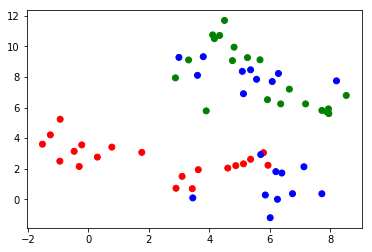

In [17]:
from matplotlib.colors import  ListedColormap

colors = ['red', 'green', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=Y_.flatten(), cmap=ListedColormap(colors))
plt.show()

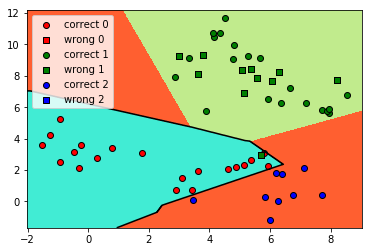

In [18]:
data.plot_decision_boundary(X, lambda x: fcann2_classify(model, x))

# graph the data points
data.graph_data(X, Y_, Y)

In [19]:
# more linearly splittable dataset
SEED2 = 118

In [20]:
np.random.seed(SEED2)

# get the training dataset
X2, Y_2 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [21]:
one_hot2 = Y_2.reshape(-1)
one_hot2 = np.eye(CLASSES)[one_hot2]

In [22]:
# train the model
model2 = fcann2_train(X2, one_hot2)
print ("Best weights at iteration:", model2['best_iter'])

iteration 1000: loss 14.30218617562224
iteration 2000: loss 11.924010737756664
iteration 3000: loss 10.700245022049652
iteration 4000: loss 9.89248184841528
iteration 5000: loss 9.302333865814099
iteration 6000: loss 8.850153984148617
iteration 7000: loss 8.49376773415513
iteration 8000: loss 8.206767604940106
iteration 9000: loss 7.973756202182349
iteration 10000: loss 7.7809604068097915
iteration 11000: loss 7.619631191628202
iteration 12000: loss 7.479831988495018
iteration 13000: loss 7.359355973592977
iteration 14000: loss 7.253235562700449
iteration 15000: loss 7.158439956107407
iteration 16000: loss 7.073175549411898
iteration 17000: loss 6.995895534049607
iteration 18000: loss 6.924892133377467
iteration 19000: loss 6.859134573461922
iteration 20000: loss 6.798316861749374
iteration 21000: loss 6.741110947520108
iteration 22000: loss 6.687473258872937
iteration 23000: loss 6.636793434730701
iteration 24000: loss 6.588350088193296
iteration 25000: loss 6.542316647510097
iteratio

In [23]:
Y2 = fcann2_classify(model2, X2)
Y2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
eval_perf(Y2, Y_2)

Accuracy: 0.983
Precision: 0.984
Recall: 0.983
F1: 0.983 


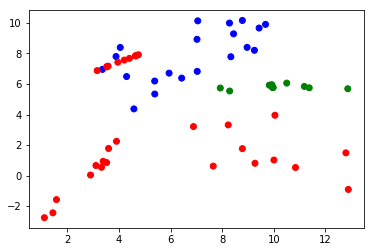

In [25]:
plt.scatter(X2[:, 0], X2[:, 1], c=Y_2.flatten(), cmap=ListedColormap(colors))
plt.show()

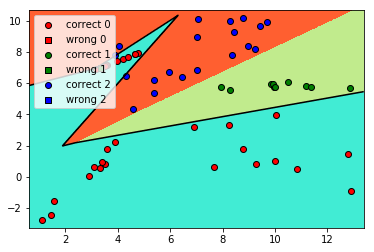

In [26]:
data.plot_decision_boundary(X2, lambda x: fcann2_classify(model2, x))

# graph the data points
data.graph_data(X2, Y_2, Y2)